#### What is the Random Forest Algorithm?
Random Forest is an ensemble learning method that builds multiple decision trees and merges their results to improve accuracy and robustness. Each tree is trained on a random subset of the data (both features and samples), and its prediction is aggregated for the final output:

- Classification: Uses majority voting among trees.
- Regression: Averages the predictions from individual trees.

Random forests aim to reduce overfitting, which is common in single decision trees, by averaging the results of multiple diverse trees.

#### Generate Random Data and Plot It (Random Forest Example)

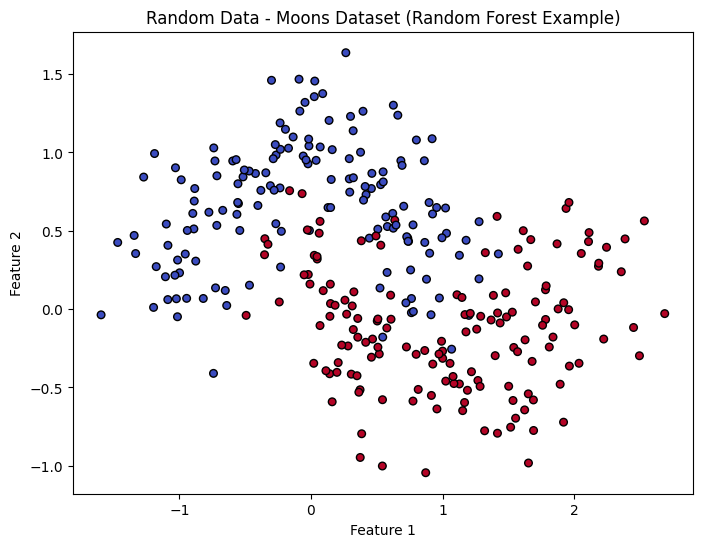

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier

# Generate random 2D classification data
X, y = make_moons(n_samples=300, noise=0.25, random_state=42)

# Plot the generated data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30, edgecolors='k')
plt.title('Random Data - Moons Dataset (Random Forest Example)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


#### Is Random Forest Good for Regression or Classification or Both?
Random Forest is used for both:

- Classification: It predicts the class label by voting across multiple decision trees.
- Regression: It predicts a continuous value by averaging the output of the decision trees.

#### Implement Random Forest from Scratch Using Numpy
Here's a simplified version of a random forest implementation. This example focuses on classification:

In [7]:
import numpy as np

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
    
    def fit(self, X, y):
        self.n_classes = len(set(y))
        self.n_features = X.shape[1]
        self.tree = self._grow_tree(X, y)
    
    def predict(self, X):
        # For each sample, traverse the tree and get the prediction
        return np.array([self._predict(inputs) for inputs in X])
    
    def _predict(self, inputs):
        # Traverse the tree until a leaf node is reached
        node = self.tree
        while node["type"] != "leaf":
            if inputs[node["feature"]] < node["threshold"]:
                node = node["left"]
            else:
                node = node["right"]
        return node["value"]
    
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if depth >= self.max_depth or len(set(y)) == 1:
            # If max depth is reached or all labels are the same, return a leaf node
            leaf_value = self._most_common_label(y)
            return {"type": "leaf", "value": leaf_value}
        
        feat_idx, threshold = self._best_split(X, y)
        if feat_idx is None:
            return {"type": "leaf", "value": self._most_common_label(y)}
        
        # Split the data
        left_indices = X[:, feat_idx] < threshold
        right_indices = ~left_indices
        left_subtree = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._grow_tree(X[right_indices], y[right_indices], depth + 1)
        return {"type": "node", "feature": feat_idx, "threshold": threshold, 
                "left": left_subtree, "right": right_subtree}
    
    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        best_gain = -1
        split_idx, split_thresh = None, None
        
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                gain = self._information_gain(X[:, feature_idx], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_idx
                    split_thresh = threshold
        
        return split_idx, split_thresh
    
    def _information_gain(self, feature_column, y, threshold):
        parent_entropy = self._entropy(y)
        
        left_indices = feature_column < threshold
        right_indices = ~left_indices
        if len(np.unique(y[left_indices])) == 0 or len(np.unique(y[right_indices])) == 0:
            return 0
        
        n = len(y)
        n_left, n_right = len(y[left_indices]), len(y[right_indices])
        if n_left == 0 or n_right == 0:
            return 0
        
        child_entropy = (n_left / n) * self._entropy(y[left_indices]) + (n_right / n) * self._entropy(y[right_indices])
        return parent_entropy - child_entropy
    
    def _entropy(self, y):
        proportions = np.bincount(y) / len(y)
        return -np.sum([p * np.log2(p) for p in proportions if p > 0])
    
    def _most_common_label(self, y):
        return np.bincount(y).argmax()

class RandomForest:
    def __init__(self, n_trees=10, max_depth=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []
    
    def fit(self, X, y):
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
    
    def predict(self, X):
        # Get predictions from all trees and take a majority vote
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.squeeze(np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_predictions))
    
    def _bootstrap_sample(self, X, y):
        # Create a bootstrap sample from the dataset
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

rf = RandomForest(n_trees=100, max_depth=10)
rf.fit(X, y)
predictions = rf.predict(X)
y[:5], predictions[:5]

(array([1, 1, 1, 0, 1]), array([1, 1, 1, 0, 1]))

##### When to Use Random Forest and When Not to Use It

When to Use:
- When interpretability is not a primary concern.
- When you want high accuracy and a robust model.
- When you have both classification and regression tasks.
- When you have a large dataset with many features.

When Not to Use:
- When you need a highly interpretable model.
- When computational resources are limited (Random Forests can be expensive to train and make predictions).
- When you have very high-dimensional data (other dimensionality reduction methods might be more efficient).

##### What is the Loss Function?
- Classification: Typically, the loss function used is Gini impurity or Entropy (information gain) to determine the quality of splits.
- Regression: The loss function is usually the Mean Squared Error (MSE).

##### How are Trees Calculated?
Random Forest constructs individual decision trees by:

- Bootstrapping the dataset (sampling with replacement).
- Randomly selecting a subset of features at each split.
- Growing trees until a stopping condition is met (e.g., maximum depth, minimum node size).
- Aggregating the results of all trees for the final prediction.


##### How to Optimize the Algorithm
- Tune Hyperparameters: Adjust n_trees, max_depth, min_samples_split, max_features, etc.
- Reduce Overfitting: Use fewer features per split (max_features), prune trees, or increase the minimum number of samples per split (min_samples_split).
- Feature Importance: Use feature importance scores to remove uninformative features.
- Bagging: Ensures robust trees by introducing randomization in both the dataset (bagging) and feature selection at each split.

##### How to Plot the Random Forest for Visualization
- For visualizing individual decision trees from a random forest, you can use scikit-learn's export_graphviz and graph visualization libraries like Graphviz:


<Figure size 1500x1000 with 0 Axes>

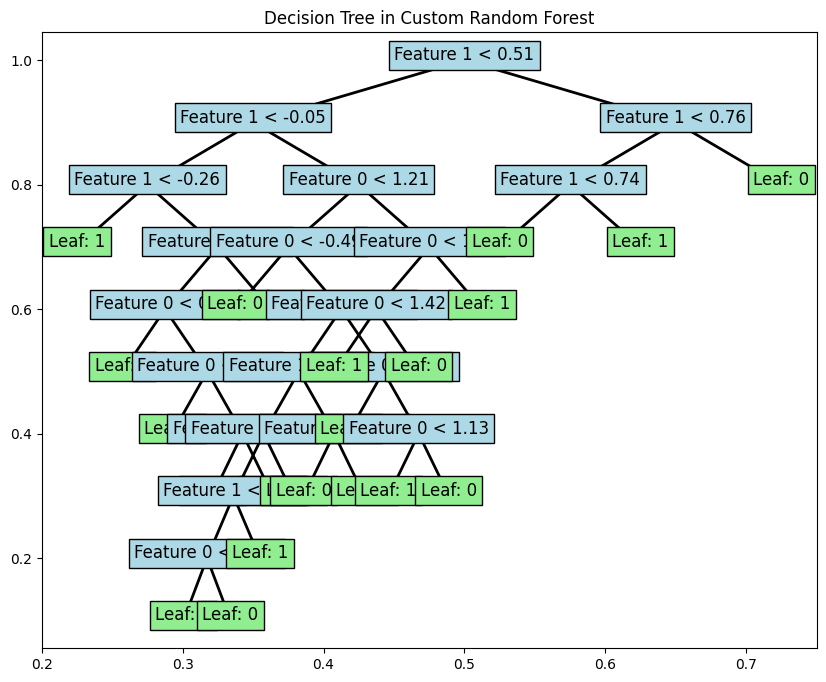

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# Recursive function to plot the tree
def plot_decision_tree(tree, depth=0, pos=(0.5, 1.0), x_offset=0.15, y_offset=0.1, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
        
    if tree['type'] == 'leaf':
        ax.text(pos[0], pos[1], f'Leaf: {tree["value"]}', fontsize=12, ha='center', bbox=dict(facecolor='lightgreen', edgecolor='black'))
        return
    
    ax.text(pos[0], pos[1], f'Feature {tree["feature"]} < {tree["threshold"]:.2f}', fontsize=12, ha='center', bbox=dict(facecolor='lightblue', edgecolor='black'))
    
    # Plot the left and right child recursively
    left_pos = (pos[0] - x_offset / (depth + 1), pos[1] - y_offset)
    right_pos = (pos[0] + x_offset / (depth + 1), pos[1] - y_offset)
    
    # Draw the lines to the children
    ax.plot([pos[0], left_pos[0]], [pos[1], left_pos[1]], 'k-', lw=2)
    ax.plot([pos[0], right_pos[0]], [pos[1], right_pos[1]], 'k-', lw=2)
    
    # Recursively plot the subtrees
    plot_decision_tree(tree['left'], depth+1, pos=left_pos, x_offset=x_offset, y_offset=y_offset, ax=ax)
    plot_decision_tree(tree['right'], depth+1, pos=right_pos, x_offset=x_offset, y_offset=y_offset, ax=ax)
    
    return ax

# Plot the first decision tree in the RandomForest you implemented
tree = rf.trees[0].tree  # Access the first decision tree

plt.figure(figsize=(15, 10))
ax = plot_decision_tree(tree)
plt.title('Decision Tree in Custom Random Forest')
plt.show()

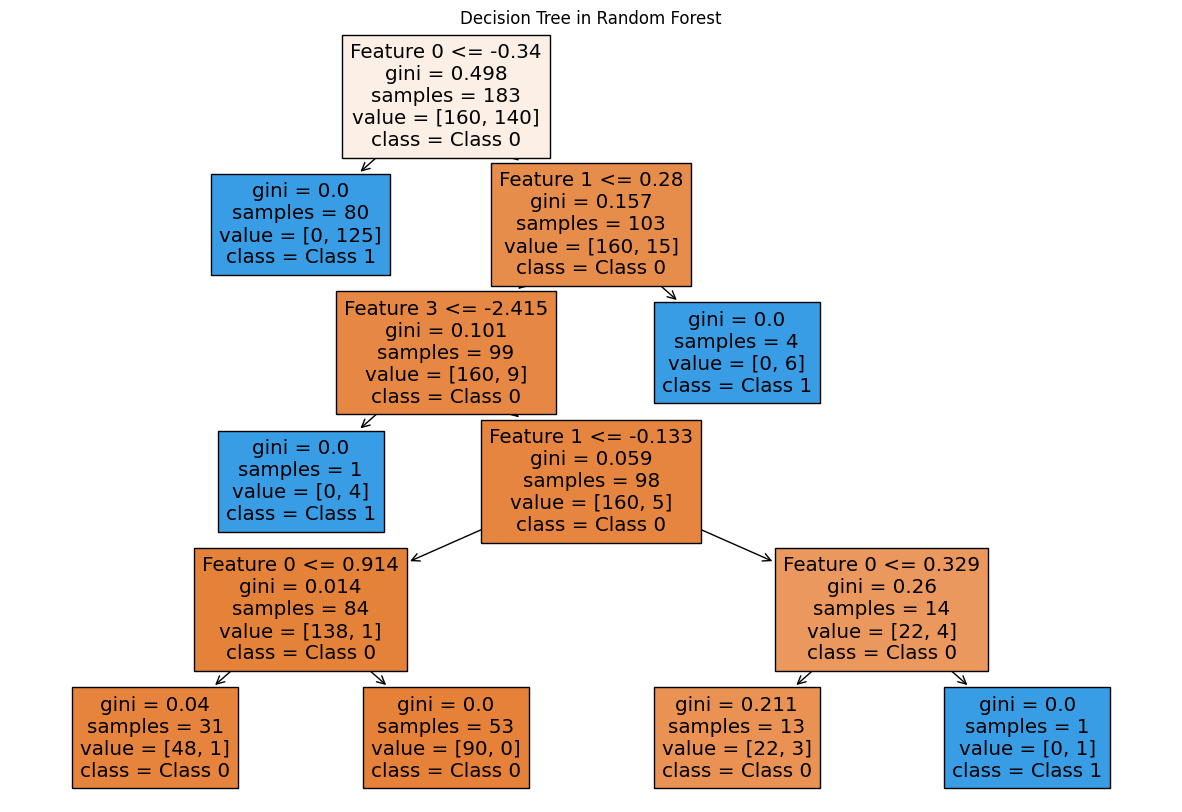

In [10]:
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Fit a random forest model
X, y = make_classification(n_samples=300, n_features=4, random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X, y)

# Visualize the first tree in the forest
plt.figure(figsize=(15, 10))
plot_tree(rf.estimators_[0], filled=True, feature_names=[f'Feature {i}' for i in range(4)], class_names=['Class 0', 'Class 1'])
plt.title('Decision Tree in Random Forest')
plt.show()


While you can technically visualize all the trees in a Random Forest, doing so can be overwhelming if the forest contains many trees. Each individual tree in a Random Forest is different, so plotting each of them can result in a large, complex set of diagrams.

Here are a few options to visualize Random Forest trees:

##### Option 1: Visualize a Subset of Trees
Instead of plotting all trees, you can visualize a few representative trees (e.g., the first 3-5 trees) from the Random Forest to understand how they work individually. Here's how you can do that:

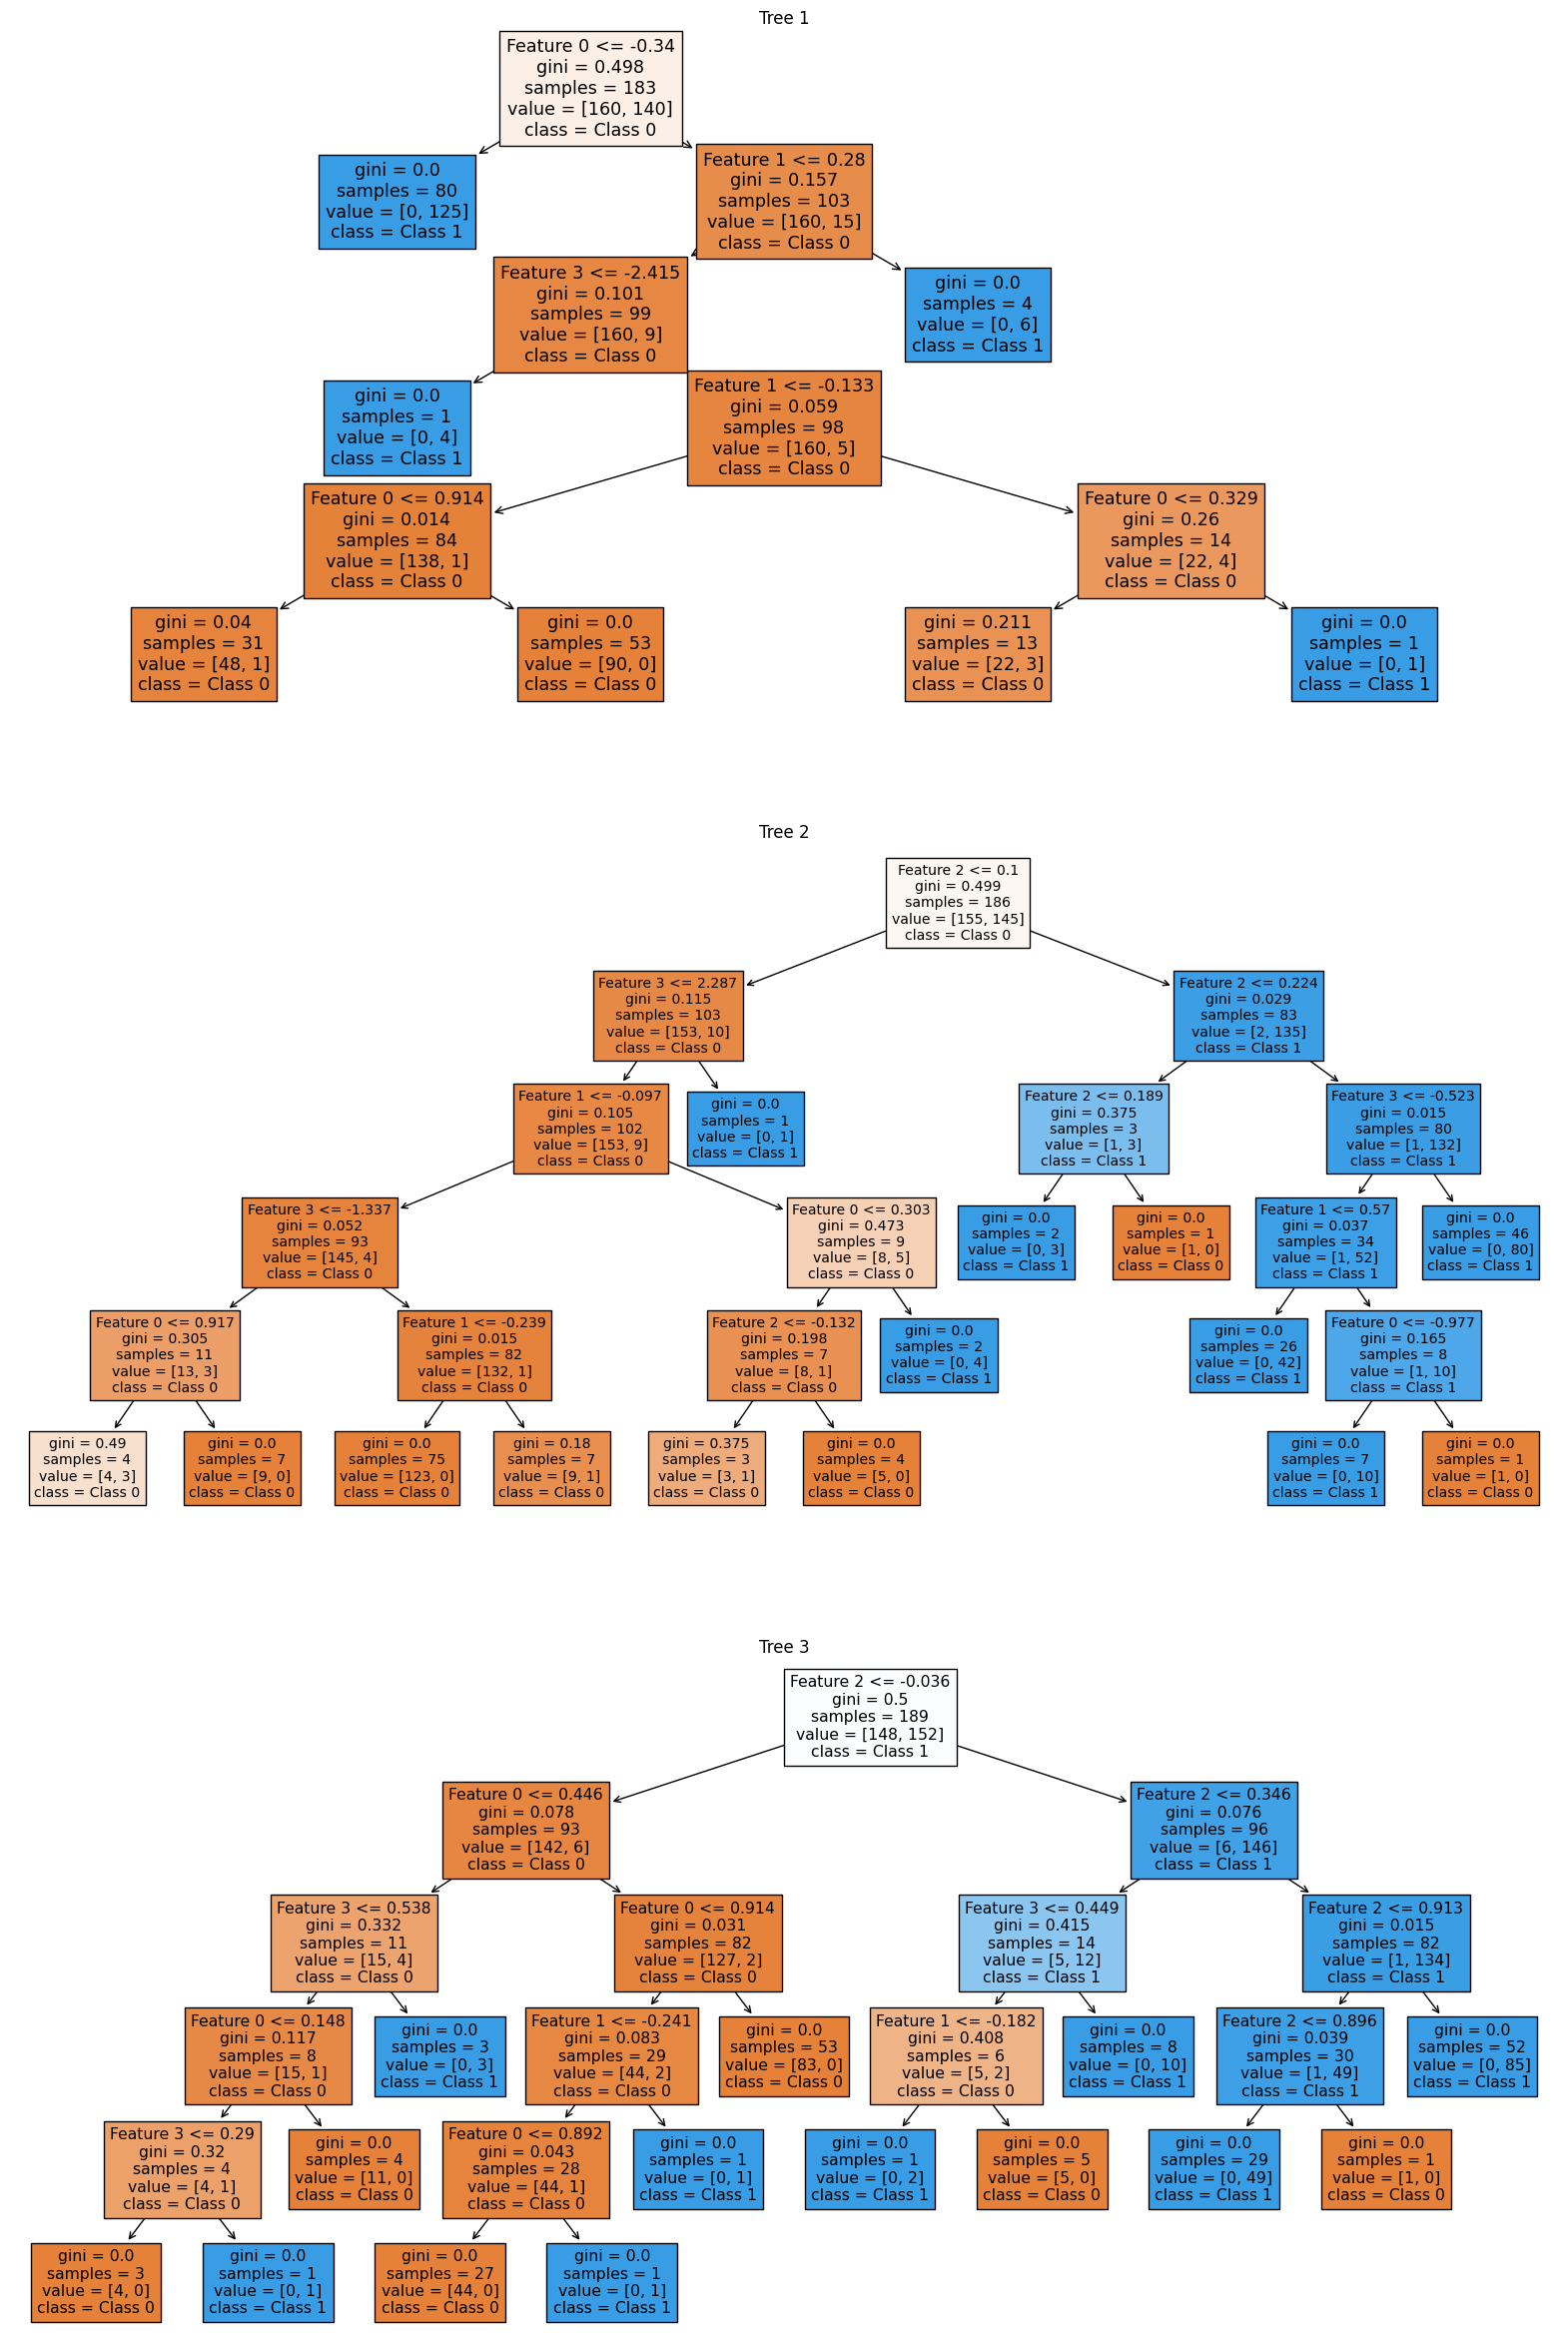

In [11]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualize the first few trees in the random forest
n_trees_to_plot = 3  # Set how many trees you want to visualize

plt.figure(figsize=(20, 10 * n_trees_to_plot))  # Adjust figure size based on number of trees
for i in range(n_trees_to_plot):
    plt.subplot(n_trees_to_plot, 1, i + 1)  # Create a subplot for each tree
    plot_tree(rf.estimators_[i], filled=True, feature_names=[f'Feature {j}' for j in range(4)], class_names=['Class 0', 'Class 1'])
    plt.title(f'Tree {i + 1}')
    
plt.show()


This will plot the first n_trees_to_plot trees from the Random Forest. You can adjust n_trees_to_plot to visualize more or fewer trees.

##### Option 2: Visualize Trees as Text
For larger forests, plotting all the trees graphically isn't practical. Instead, you can generate a text-based representation of each tree, which is more scalable:

In [12]:
from sklearn.tree import export_text

# Visualize the first few trees as text
for i in range(3):  # Adjust how many trees to print
    tree_text = export_text(rf.estimators_[i], feature_names=[f'Feature {j}' for j in range(4)])
    print(f'Tree {i + 1}:\n')
    print(tree_text)
    print("\n" + "-"*80 + "\n")


Tree 1:

|--- Feature 0 <= -0.34
|   |--- class: 1.0
|--- Feature 0 >  -0.34
|   |--- Feature 1 <= 0.28
|   |   |--- Feature 3 <= -2.41
|   |   |   |--- class: 1.0
|   |   |--- Feature 3 >  -2.41
|   |   |   |--- Feature 1 <= -0.13
|   |   |   |   |--- Feature 0 <= 0.91
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Feature 0 >  0.91
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- Feature 1 >  -0.13
|   |   |   |   |--- Feature 0 <= 0.33
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Feature 0 >  0.33
|   |   |   |   |   |--- class: 1.0
|   |--- Feature 1 >  0.28
|   |   |--- class: 1.0


--------------------------------------------------------------------------------

Tree 2:

|--- Feature 2 <= 0.10
|   |--- Feature 3 <= 2.29
|   |   |--- Feature 1 <= -0.10
|   |   |   |--- Feature 3 <= -1.34
|   |   |   |   |--- Feature 0 <= 0.92
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Feature 0 >  0.92
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- Fea

This will print a human-readable text representation of the trees.

##### Option 3: Visualize All Trees in a Grid
If you want to visualize all trees but keep it compact, you can arrange the plots in a grid. However, note that this might still be overwhelming if you have too many trees in your forest:

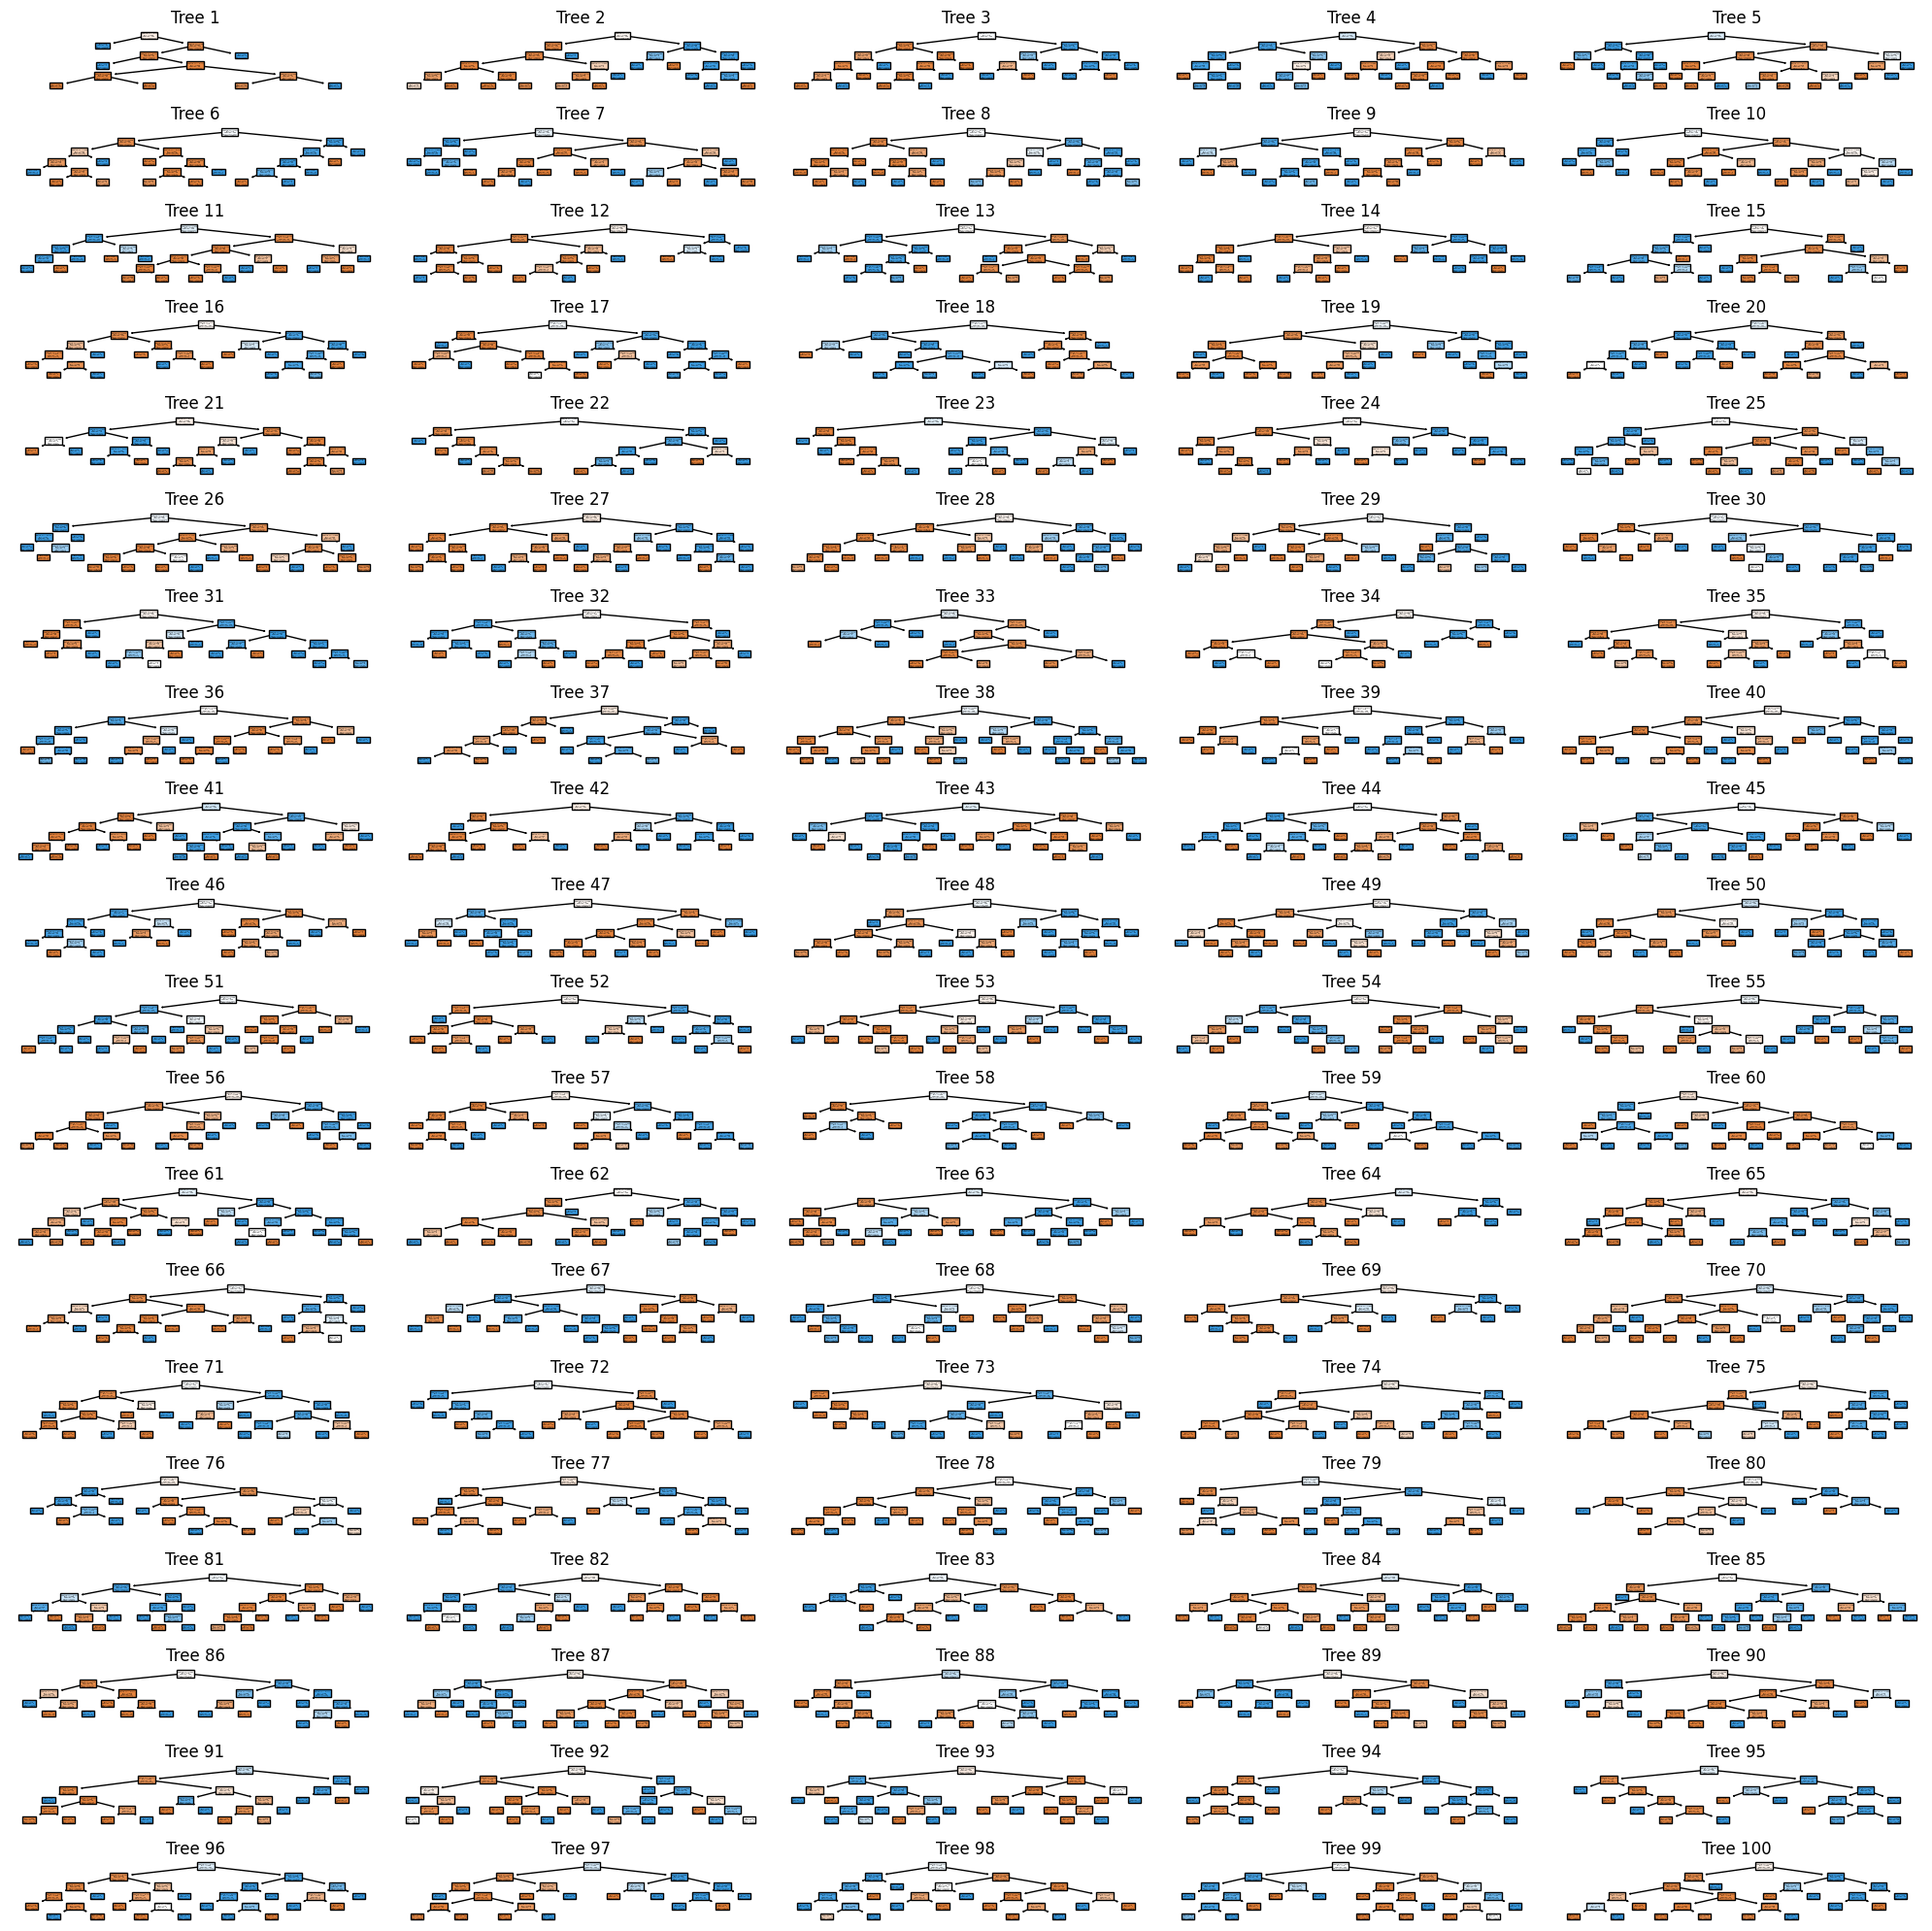

In [13]:
import math

n_trees = len(rf.estimators_)
n_cols = 5  # Number of columns in the grid
n_rows = math.ceil(n_trees / n_cols)  # Automatically calculate rows based on the number of trees

plt.figure(figsize=(20, 20))  # Adjust figure size

for i in range(n_trees):
    plt.subplot(n_rows, n_cols, i + 1)  # Create a grid of subplots
    plot_tree(rf.estimators_[i], filled=True, feature_names=[f'Feature {j}' for j in range(4)], class_names=['Class 0', 'Class 1'])
    plt.title(f'Tree {i + 1}')
    
plt.tight_layout()
plt.show()


This approach allows you to visualize all trees in a compact form, but depending on how many trees there are, it may not be practical to view them all at once.

##### Option 4: Feature Importance Visualization
Rather than visualizing every individual tree, you might find it more insightful to visualize feature importance, which summarizes the contribution of each feature across all trees:

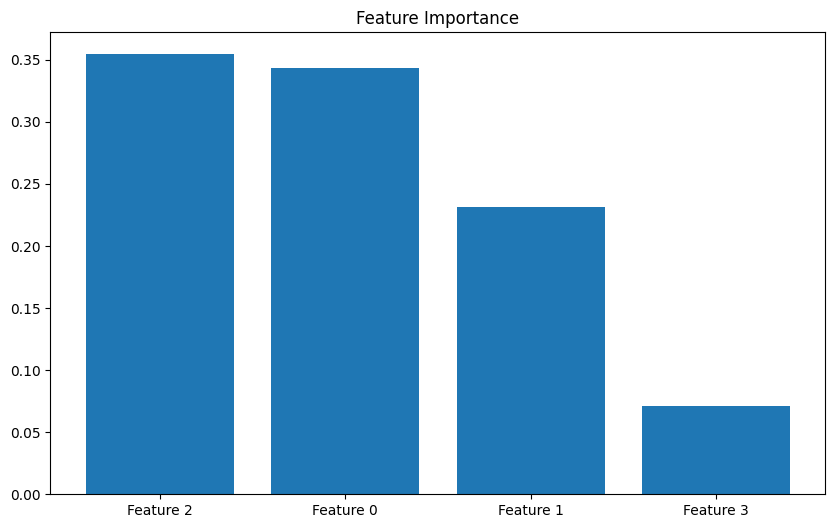

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [f'Feature {i}' for i in indices])
plt.show()


This method helps focus on the importance of each feature, summarizing the influence of features across all trees in the forest.

In a random forest, feature importance can be calculated using the same methods as in a single decision tree, but averaged across all trees:

- Mean Decrease Impurity: This is the average of the Gini importance of a feature calculated from all the trees in the forest. Each feature's importance is summed up across all trees, giving a clear indication of its influence.

- Mean Decrease Accuracy (Permutation Importance): Similar to the permutation importance in decision trees, this method can also be applied in a random forest context. You randomly shuffle the values of a feature and measure the decrease in the accuracy of the model across all trees, averaging the results.

#### Pros and Cons of Using Feature Importance
Pros:
- Interpretability: Feature importance provides insights into which features contribute the most to the model's predictions, aiding in understanding the model's behavior and decisions.

- Dimensionality Reduction: By identifying and removing less important features, you can simplify the model, which can lead to faster training times and improved performance.

- Identifying Relationships: It helps in recognizing underlying relationships and dependencies between features and the target variable.

- Model Debugging: If certain features are expected to be important based on domain knowledge but have low importance scores, this might indicate potential issues with data quality or model specifications.

Cons:
- Bias Toward Numerical Features: Decision trees tend to favor numerical features or features with many unique values, which can lead to misleading importance scores in certain datasets.

- Feature Correlation: If features are highly correlated, the importance scores can be distributed among them, making it difficult to assess the individual contribution of each feature accurately.

- Instability in Small Datasets: Feature importance can vary significantly with small changes in the data, especially in small datasets or with trees that are very sensitive to the training data.

- Not Always Reflective of True Importance: A feature may be deemed important in one context (or one subset of the data) but may not be important in another. It's essential to interpret feature importance scores in the context of the data and the specific problem.

#### How Bootstrap Sampling Helps in Random Forests

Bootstrap sampling is a key technique that contributes to the effectiveness of random forests. Here's how it helps:   

#### Reduced Overfitting
- By creating multiple trees on different subsets of the data, each tree is exposed to a slightly different view of the data.   
- This diversity helps to reduce overfitting, as each tree is less likely to memorize the training data.   

#### Improved Generalization
- The ensemble of trees, each trained on a different subset of data, can make more robust predictions.   
- This leads to better generalization performance on unseen data.   

#### Variance Reduction
- The averaging of predictions from multiple trees helps to reduce the variance of the model.   
- This means that the model is less sensitive to noise in the training data.


#### Building a Random Forest: A Step-by-Step Example

Let's consider a simple dataset:

| Age | Income | Buys Car |
|-----|--------|----------|
| 25  | 40K    | No       |
| 30  | 50K    | Yes      |
| 35  | 60K    | Yes      |
| 40  | 70K    | Yes      |
| 45  | 80K    | Yes      |


#### Building a Single Decision Tree

**1. Choose a Root Node**  
- Use the `Income` feature as the root node since it has a strong correlation with `Buys Car`.

**2. Split the Data**  
- Split based on a threshold of `55K`:  
  - Data points with `Income <= 55K` go to the left child node.  
  - Data points with `Income > 55K` go to the right child node.

**3. Create Child Nodes**  
- **Left Child Node**:  
  - Data points: {(25, 40K, No), (30, 50K, Yes)}  
  - Use `Age` as the splitting feature with a threshold of `27.5`.  

- **Right Child Node**:  
  - Data points: {(35, 60K, Yes), (40, 70K, Yes), (45, 80K, Yes)}  
  - All data points have the label `Yes`, making it a leaf node.

**4. Continue the Process**  
- For the left child node, further split based on `Age`.  

**Final Tree Structure**:  

               Income <= 55K
              /              \
        Age <= 27.5         Income > 55K
        /        \                \
      No         Yes              Yes



#### Building a Random Forest

**1. Bootstrap Sampling**  
- Randomly select subsets of data points with replacement.

**2. Feature Selection**  
- Randomly select subsets of features for each split.

**3. Tree Building**  
- Build a decision tree using the selected data and features.

**4. Repeat**  
- Repeat steps 1–3 to create multiple trees.


#### Making Predictions

1. Pass the new data point through each tree in the forest.  
2. Each tree outputs a prediction.  
3. Combine predictions:  
   - **Classification**: Use majority voting.  
   - **Regression**: Use the average of predictions.

By combining multiple trees, random forests improve accuracy and reduce overfitting.


#### Why Bootstrap Sampling with Replacement?

Bootstrap sampling with replacement is a core principle of **bagging** (Bootstrap Aggregating) and a key reason for the effectiveness of random forests. Here's why:


**1. Reduced Variance**  
- Sampling with replacement creates diverse subsets of data, each with a slightly different distribution.  
- This diversity reduces the variance of individual trees.  
- Averaging predictions across these diverse trees further lowers the overall variance.


**2. Improved Generalization**  
- Some data points may appear multiple times in a bootstrap sample, while others may be excluded.  
- This variability creates trees less sensitive to specific data points, improving generalization to unseen data.


**3. Handling Imbalanced Datasets**  
- For datasets with underrepresented classes, bootstrap sampling can help balance class distribution within each tree.  
- This improves model performance on the minority class.


**Why Not Sample Without Replacement?**  
- Sampling without replacement would result in subsets that closely resemble the original dataset.  
- This reduces diversity across trees, limiting the benefits of ensemble learning.

Bootstrap sampling with replacement ensures diversity and robustness, making it a powerful technique in random forests.
